# Курсовой проект "Прогнозирование цен на недвижимость"

### Задание для курсового проекта

Данные:
https://www.kaggle.com/c/real-estate-price-prediction-moscow/leaderboard

Мой аккаунт:
https://www.kaggle.com/alexartwww

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Сдать проект нужно в течение 7 дней после окончания последнего вебинара.
2. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
3. Необходимо получить R2 > 0.6 на Private Leaderboard.
4. Укажите свой ник на kaggle 


Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.
____________
Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров. 

**План занятия**
* [Загрузка данных](#load)
* [1. EDA](#eda)
* [2. Обработка выбросов](#outlier)
* [3. Обработка пропусков](#nan)
* [4. Построение новых признаков](#feature)
* [5. Отбор признаков](#feature_selection)
* [6. Разбиение на train и test](#split)
* [7. Построение модели](#modeling)
* [8. Прогнозирование на тестовом датасете](#prediction)

**Подключение библиотек и скриптов**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./input/real-estate-price-prediction-moscow/sample_submission.csv
./input/real-estate-price-prediction-moscow/train.csv
./input/real-estate-price-prediction-moscow/test.csv


In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
matplotlib.rcParams.update({'font.size': 14})

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 5)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 5)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [6]:
TRAIN_DATASET_PATH = './input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = './input/real-estate-price-prediction-moscow/test.csv'

### Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [8]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [9]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [10]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [11]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Приведение типов

In [12]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [13]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## 1. EDA  <a class='anchor' id='eda'>
Делаем EDA для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

**Целевая переменная**

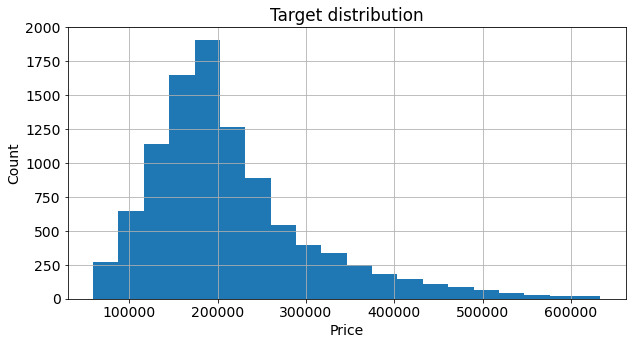

In [14]:
plt.figure(figsize = (10, 5))

train_df['Price'].hist(bins=20)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [15]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Анализ данных по колонкам
==

**Rooms**

In [16]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

* Заменяем 0 и NaN на 1
* удаляем записи больше 6 комнат

In [17]:
def fix_rooms(X):
    X.loc[(X['Rooms'] == 0) | (X['Rooms'].isna()), 'Rooms'] = 1
    X.drop(X.loc[(X['Rooms'] > 6)].index, inplace=True)
    return X

df = fix_rooms(train_df)
df['Rooms'].value_counts()

2.0    3880
1.0    3713
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

**Square**

In [18]:
train_df['Square'].describe()

count    9997.000000
mean       56.316477
std        21.061338
min         1.136859
25%        41.773176
50%        52.512769
75%        65.904217
max       641.065193
Name: Square, dtype: float64

Видно, что есть проблемы, поэтому отрежем по 10% с начала и с конца распределения.

NaN заменим средним

In [19]:
def fix_square(X, cut_percent=0.1):
    min = X['Square'].quantile(cut_percent)
    max = X['Square'].quantile(1 - cut_percent)
    X.loc[(X['Square'].isna()), 'Square'] = X['Square'].mean()
    X.drop(X.loc[(X['Square'] < min) | (X['Square'] > max)].index, inplace=True)
    return X

df = fix_square(train_df)
df['Square'].describe()

count    7997.000000
mean       54.177861
std        12.271905
min        36.992899
25%        43.095135
50%        52.512769
75%        63.378765
max        80.853653
Name: Square, dtype: float64

**LifeSquare**

In [20]:
train_df['LifeSquare'].describe()

count    6252.000000
mean       35.069486
std        14.845398
min         0.370619
25%        24.742651
50%        33.104997
75%        43.506850
max       461.463614
Name: LifeSquare, dtype: float64

Аналогично, есть проблемы. Отрезаем по 10%, NaN заменяем на среднее. Если жилая площадь больше общей - удаляем.

In [21]:
def fix_life_square(X, cut_percent=0.1):
    min = X['LifeSquare'].quantile(cut_percent)
    max = X['LifeSquare'].quantile(1 - cut_percent)
    X.loc[(X['LifeSquare'].isna()), 'LifeSquare'] = X['LifeSquare'].mean()
    X.drop(X.loc[(X['LifeSquare'] < min) | (X['LifeSquare'] > max) | (X['LifeSquare'] > X['Square'])].index, inplace=True)
    return X

df = fix_life_square(train_df)
df['LifeSquare'].describe()

count    6586.000000
mean       34.099920
std         7.124429
min        20.543958
25%        30.201771
50%        35.069486
75%        36.378661
max        50.547200
Name: LifeSquare, dtype: float64

**KitchenSquare**

In [22]:
train_df['KitchenSquare'].describe()

count    6586.000000
mean        6.190100
std        25.094506
min         0.000000
25%         1.000000
50%         6.000000
75%         9.000000
max      2014.000000
Name: KitchenSquare, dtype: float64

Заменяем меньше 6 на 6. Если жилая площадь больше общей - удаляем.

In [23]:
def fix_kitchen_square(X, low_fix=6):
    X.loc[(X['KitchenSquare'].isna()) | (X['KitchenSquare'] < low_fix), 'KitchenSquare'] = low_fix
    X.drop(X.loc[(X['KitchenSquare'] > X['Square'])].index, inplace=True)
    return X

df = fix_kitchen_square(train_df)
df['KitchenSquare'].describe()

count    6585.000000
mean        7.507062
std         2.685972
min         6.000000
25%         6.000000
50%         6.000000
75%         9.000000
max        75.000000
Name: KitchenSquare, dtype: float64

**HouseFloor**

In [24]:
train_df['HouseFloor'].describe()

count    6585.000000
mean       12.731207
std         6.304016
min         0.000000
25%         9.000000
50%        14.000000
75%        17.000000
max        99.000000
Name: HouseFloor, dtype: float64

Есть проблема с нулевым этажом. Заменим его на самый популярный

In [25]:
def fix_house_floor(X):
    X.loc[(X['HouseFloor'].isna()) | (X['HouseFloor'] < 1), 'HouseFloor'] = X['HouseFloor'].mode()
    return X

df = fix_house_floor(train_df)
df['HouseFloor'].describe()

count    6409.000000
mean       13.080824
std         6.021473
min         1.000000
25%         9.000000
50%        14.000000
75%        17.000000
max        99.000000
Name: HouseFloor, dtype: float64

**Floor**

In [26]:
train_df['Floor'].describe()

count    6585.000000
mean        8.482156
std         5.046656
min         1.000000
25%         4.000000
50%         7.000000
75%        12.000000
max        42.000000
Name: Floor, dtype: float64

Проблем вроде нет, но мы добавим фильтры на NaN, меньше 1 и больше чем этажей в доме с заменой на самый популярный

In [27]:
def fix_floor(X):
    X.loc[(X['Floor'].isna()) | (X['Floor'] < 1) | (X['Floor'] > X['HouseFloor']), 'Floor'] = X['Floor'].mode()
    return X

df = fix_floor(train_df)
df['Floor'].describe()

count    5665.000000
mean        8.022065
std         4.835468
min         1.000000
25%         4.000000
50%         7.000000
75%        11.000000
max        42.000000
Name: Floor, dtype: float64

**HouseYear**

In [28]:
train_df['HouseYear'].describe()

count    6585.000000
mean     1983.450873
std        40.385608
min      1912.000000
25%      1973.000000
50%      1977.000000
75%      1993.000000
max      4968.000000
Name: HouseYear, dtype: float64

Проблемы со значениями больше текущего года. Больше текущего года NaN заменим на самый популярный

In [29]:
def fix_house_year(X):
    X.loc[(X['HouseYear'].isna()) | (X['HouseYear'] > datetime.today().year), 'HouseYear'] = X['HouseYear'].mode()
    return X

df = fix_house_year(train_df)
df['HouseYear'].describe()

count    6584.000000
mean     1982.997570
std        16.671172
min      1912.000000
25%      1973.000000
50%      1977.000000
75%      1993.000000
max      2020.000000
Name: HouseYear, dtype: float64

**Ecology_1**

In [30]:
train_df['Ecology_1'].describe()

count    6585.000000
mean        0.119493
std         0.119905
min         0.000000
25%         0.017647
50%         0.075779
75%         0.195781
max         0.521867
Name: Ecology_1, dtype: float64

На вид проблем нет, но если будут пропуски заменим на средние по району. Если в районе все NaN - просто на среднее.

In [32]:
def fix_by_districts_mean(X, column):
    df = X.groupby('DistrictId')
    means = df[column].mean().to_dict()
    for DistrictId in means:
        X.loc[(X[column].isna()) & (X['DistrictId'] == DistrictId), column] = means[DistrictId] if not np.isnan(means[DistrictId]) else X[column].mode()
    return X

df = fix_by_districts_mean(df, 'Ecology_1')
df['Ecology_1'].describe()

count    6585.000000
mean        0.119493
std         0.119905
min         0.000000
25%         0.017647
50%         0.075779
75%         0.195781
max         0.521867
Name: Ecology_1, dtype: float64

**Healthcare_1**

In [33]:
train_df['Healthcare_1'].describe()

count    3528.000000
mean     1127.209751
std      1016.576947
min         0.000000
25%       325.000000
50%       900.000000
75%      1547.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

То же что и Ecology_1

In [39]:
df = fix_by_districts_mean(df, 'Healthcare_1')
df['Healthcare_1'].describe()

count    5384.000000
mean     1023.710478
std       995.029866
min         0.000000
25%       228.181818
50%       750.000000
75%      1406.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

**Ecology_2, Ecology_3, Shops_2**

Просто автозамена по словарю

In [40]:
def fix_by_dict(X, column, replace):
    X[column] = X[column].replace(replace)
    return X


# binary_to_numbers = {'A': 0, 'B': 1}

# df = fix_by_dict(train_df, 'Ecology_2', binary_to_numbers)
# df = fix_by_dict(df, 'Ecology_3', binary_to_numbers)
# df = fix_by_dict(df, 'Shops_2', binary_to_numbers)

# df['Shops_2'].value_counts()

**Social_1, Social_2, Social_3, Helthcare_2, Shops_1**

In [41]:
def fix_by_mode(X, column):
    X.loc[(X[column].isna()), column] = X[column].mode()
    return X

# df = fix_by_mode(train_df, 'Social_1')
# df = fix_by_mode(train_df, 'Social_2')
# df = fix_by_mode(train_df, 'Social_3')
# df = fix_by_mode(train_df, 'Helthcare_2')
# df = fix_by_mode(train_df, 'Shops_1')


DataPreprocessing class
==

In [42]:
class DataDrop:
    def drop(self, X):
        X = self.drop_rooms(X)
        X = self.drop_square(X)
        X = self.drop_life_square(X)
        X = self.drop_kitchen_square(X)
        return X

    def drop_rooms(self, X):
        X.drop(X.loc[(X['Rooms'] > 6)].index, inplace=True)
        return X

    def drop_square(self, X, cut_percent=0.1):
        min = X['Square'].quantile(cut_percent)
        max = X['Square'].quantile(1 - cut_percent)
        X.drop(X.loc[(X['Square'] < min) | (X['Square'] > max)].index, inplace=True)
        return X

    def drop_life_square(self, X, cut_percent=0.1):
        min = X['LifeSquare'].quantile(cut_percent)
        max = X['LifeSquare'].quantile(1 - cut_percent)
        X.drop(X.loc[(X['LifeSquare'] < min) | (X['LifeSquare'] > max) | (X['LifeSquare'] > X['Square'])].index, inplace=True)
        return X

    def drop_kitchen_square(self, X):
        X.drop(X.loc[(X['KitchenSquare'] > X['Square'])].index, inplace=True)
        return X

In [43]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.districts = None
        self.means = None
        self.modes = None
        self.districtMeans = None
        
    def fit(self, X):
        """Сохранение статистик"""
        self.means = X.mean()
        self.modes = {}
        for column in X.columns:
            self.modes[column] = X[column].mode()[0]
        self.districtMeans = {}
        self.districts = X['DistrictId'].unique()
        df = X.groupby('DistrictId')
        for column in ['Ecology_1', 'Healthcare_1']:
            self.districtMeans[column] = df[column].mean().to_dict()
        self.binary_to_numbers = {'A': 0, 'B': 1}

    def transform(self, X):
        """Трансформация данных"""

        X = self.fix_rooms(X)
        X = self.fix_square(X)
        X = self.fix_life_square(X)
        X = self.fix_kitchen_square(X)
        X = self.fix_house_floor(X)
        X = self.fix_floor(X)
        X = self.fix_house_year(X)
        X = self.fix_by_districts_mean(X, 'Ecology_1')
        X = self.fix_by_districts_mean(X, 'Healthcare_1')
        X = self.fix_by_dict(X, 'Ecology_2', self.binary_to_numbers)
        X = self.fix_by_dict(X, 'Ecology_3', self.binary_to_numbers)
        X = self.fix_by_dict(X, 'Shops_2', self.binary_to_numbers)
        X = self.fix_by_mode(X, 'Social_1')
        X = self.fix_by_mode(X, 'Social_2')
        X = self.fix_by_mode(X, 'Social_3')
        X = self.fix_by_mode(X, 'Helthcare_2')
        X = self.fix_by_mode(X, 'Shops_1')
        return X
  
    def fix_rooms(self, X):
        X.loc[(X['Rooms'] == 0) | (X['Rooms'].isna()), 'Rooms'] = 1
        return X

    def fix_square(self, X):
        X.loc[(X['Square'].isna()), 'Square'] = X['Square'].mean()
        return X

    def fix_life_square(self, X):
        X.loc[(X['LifeSquare'].isna()), 'LifeSquare'] = X['LifeSquare'].mean()
        return X

    def fix_kitchen_square(self, X, low_fix=6):
        X.loc[(X['KitchenSquare'].isna()) | (X['KitchenSquare'] < low_fix), 'KitchenSquare'] = low_fix
        return X

    def fix_house_floor(self, X):
        X.loc[(X['HouseFloor'].isna()) | (X['HouseFloor'] < 1), 'HouseFloor'] = X['HouseFloor'].mode()[0]
        return X

    def fix_floor(self, X):
        X.loc[(X['Floor'].isna()) | (X['Floor'] < 1) | (X['Floor'] > X['HouseFloor']), 'Floor'] = X['Floor'].mode()[0]
        return X

    def fix_house_year(self, X):
        X.loc[(X['HouseYear'].isna()) | (X['HouseYear'] > datetime.today().year), 'HouseYear'] = X['HouseYear'].mode()[0]
        return X

    def fix_by_districts_mean(self, X, column):
#         if column in self.districtMeans:
#             for DistrictId in self.districts:
#                 if DistrictId in self.districtMeans[column] and not np.isnan(self.districtMeans[column][DistrictId]):
#                     X.loc[(X[column].isna()) & (X['DistrictId'] == DistrictId), column] = self.districtMeans[column][DistrictId]
        X.loc[(X[column].isna()), column] = X[column].mean()
        return X

    def fix_by_dict(self, X, column, replace):
        X[column] = X[column].replace(replace)
        X.loc[(X[column].isna()), column] = X[column].mode()[0]
        return X

    def fix_by_mode(self, X, column):
        X.loc[(X[column].isna()), column] = X[column].mode()[0]
        return X


### 4. Построение новых признаков  <a class='anchor' id='feature'>

In [44]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        X = X.copy()
        # Target encoding
        ## District, Rooms
        df = X.copy()
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
    def transform(self, X):
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.floor_to_first_or_last(X)  # + столбец first_or_last
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X

    def floor_to_first_or_last(self, X):
        X['floor_first_or_last'] = 0
        X.loc[(X['Floor'] == 1) | (X['Floor'] == X['HouseFloor']), 'floor_first_or_last'] = 1
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X


### 5. Отбор признаков  <a class='anchor' id='feature_selection'>

In [45]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']
new_feature_names = [
# Доп фичи все портят...
#                      'DistrictSize',
#                      'new_district',
#                      'IsDistrictLarge',
#                      #'MedPriceByDistrict',
#                      'MedPriceByFloorYear',
#                      'floor_cat',
#                      'floor_first_or_last',
#                      'year_cat'
                    ]

target_name = 'Price'

### 6. Разбиение на train и test  <a class='anchor' id='split'>

In [46]:
dropper = DataDrop()

In [47]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
# train_df = dropper.drop(train_df) # Дроппер все портит
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [48]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [49]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 19), (3300, 19), (5000, 19))

In [50]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 27), (3300, 27), (5000, 27))

In [51]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [52]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [53]:
X_train.isna().sum()

DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

### 7. Построение модели  <a class='anchor' id='modeling'>

#### Подборка параметров

In [54]:
# x = [100,150,175,190,200,210,225,250,300,400,500]
# y = []
# for param in x:
#     rf_model = GradientBoostingRegressor(criterion='friedman_mse',
#                                             max_depth=4,
#                                             min_samples_leaf=0.0001,
#                                             random_state=42,
#                                             n_estimators=param)
#     rf_model.fit(X_train, y_train)
#     y_train_preds = rf_model.predict(X_train)
#     y_test_preds = rf_model.predict(X_valid)
#     y.append(r2(y_valid, y_test_preds))

# plt.plot(x, y)

# plt.show()

**Обучение**

In [55]:
rf_model_linear = LinearRegression()
rf_model_forest = RandomForestRegressor(
    random_state=21,
    criterion='mse',
    max_depth=None,
    min_samples_split = 2,
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0,
    max_features = 'auto',
    max_leaf_nodes = None,
    min_impurity_decrease = 0.0,
    bootstrap = True,
    oob_score = False,
    n_jobs = None,
    ccp_alpha = 0.0,
    max_samples = None
)
rf_model_gradient = GradientBoostingRegressor(criterion='friedman_mse',
                                        max_depth=4,
                                        min_samples_leaf=0.0001,
                                        random_state=42,
                                        n_estimators=190) # best for kaggle = 500
rf_model = rf_model_gradient # VotingRegressor(estimators=[('gb', rf_model_gradient), ('rf', rf_model_forest), ('lr', rf_model_linear)])
rf_model.fit(X_train, y_train)

NameError: name 'GradientBoostingRegressor' is not defined

**Оценка модели**

In [ ]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация**

In [ ]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

In [ ]:
cv_score.mean()

**Важность признаков**

In [ ]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

### 8. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [ ]:
test_df.shape

In [ ]:
test_df

In [ ]:
submit = pd.read_csv('./input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

In [ ]:
predictions = rf_model.predict(test_df)
predictions

In [ ]:
submit['Price'] = predictions
submit.head()

In [ ]:
submit.to_csv('rf_submit.csv', index=False)

Выводы
==

Что сработало в минус:

1. На мой взгляд дополнительные фичи все портят - это производные данные и их по понижению размерности нужно убирать. На кегле не удалось поднять рейтинг благодаря им.
1. Идея с удалением исходных данных прям сильно плохая. Дроппер портит предсказание оч. сильно.
1. Средние по районам работают хуже, чем средние в целом. Тоже отказался от этой идеи.
1. Оценка модели в ноутбуке на соответствует оценке на кегле

Что сработало в плюс:

1. Изменил модель на градиентный бустинг
1. Тюнил параметры с использованием графика
1. Сталкивался с переобучением и откатывался назад.

Итог

1. На кегле 47 место с 0.74471 баллами